# 0. Setup

## General

In [27]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
from tabpfn_time_series import TimeSeriesDataFrame, TabPFNTimeSeriesPredictor, TabPFNMode
from tabpfn import TabPFNRegressor
import statsmodels

RANDOM_STATE = 42

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [3]:
# Data folders
from pathlib import Path

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'brexit': ax.axvspan(pd.Timestamp('2016-06'), pd.Timestamp('2017-06'),
                             color="orange", alpha=0.2, label='Post Brexit volatility'),
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FE7B4BA0", alpha=0.2, label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FE7B4BA0", alpha=0.2, label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FE7B4BA0", alpha=0.2, label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FB3B38", alpha=0.2, label='Energy-price crisis')
    }

## Data Load

In [14]:
df = pd.read_csv('../data/processed/uk_final.csv',
                 parse_dates=['date'], index_col='date').asfreq('M')

In [ ]:
with open('../data/processed/splits.pkl', 'rb') as f:
    D = pickle.load(f)
X_tr, y_tr = D['X_train'], D['y_train']
X_ca, y_ca = D['X_cal'], D['y_cal']
X_te, y_te = D['X_test'], D['y_test']
print('Shapes:', X_tr.shape, X_ca.shape, X_te.shape)

Shapes: (71, 5) (12, 5) (42, 5)


In [6]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2015-02-28 to 2020-12-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cp_85                 71 non-null     int64  
 1   is_outlier            71 non-null     bool   
 2   lag_1                 71 non-null     float64
 3   CPI_t-1               71 non-null     float64
 4   Consumer_conf_diff_1  71 non-null     float64
dtypes: bool(1), float64(3), int64(1)
memory usage: 2.8 KB


# 1. Model Wrappers

## CatBoostRegressor

In [ ]:

class CatBoostWrapper:

    def __init__(self, **catboost_params):
        default_params = {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 6,
            'random_seed': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }

        default_params.update(catboost_params)

        self.model = CatBoostRegressor(**default_params)
        self.is_fitted = False
        self.feature_names = None
        self.feature_names_ = None
        self.predictions = {}

    def fit(self, X_train, y_train, X_val=None, y_val=None, categorical_features=None):
        if isinstance(X_train, pd.DataFrame):
            self.feature_names = X_train.columns.tolist()

        # Identify categorical features automatically if not specified
        if categorical_features is None and isinstance(X_train, pd.DataFrame):
            categorical_features = []
            for col in X_train.columns:
                if X_train[col].dtype in ['object', 'category', 'bool']:
                    categorical_features.append(col)

        eval_set = None
        if X_val is not None and y_val is not None:
            eval_set = [(X_val, y_val)]

        self.model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            cat_features=categorical_features,
            use_best_model=True if eval_set else False
        )

        self.feature_names_ = self.model.feature_names_

        self.is_fitted = True
        return self

    def get_feature_importance(self):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before getting feature importance")

        importance = self.model.get_feature_importance()
        feature_names = self.model.feature_names_

        return (
            pd.DataFrame({'feature': feature_names, 'importance': importance})
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
        )

    def predict(self, X, dataset_name='test'):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        predictions = self.model.predict(X)
        self.predictions[dataset_name] = predictions
        return predictions


    def conformal_error(self, X_cal, y_cal):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before calculating conformal errors")
            
        # Use a different dataset name to avoid overwriting other predictions
        cal_predictions = self.predict(X_cal, dataset_name='calibration_conformal')
        return np.abs(y_cal - cal_predictions)


## TabPFN_TS

In [37]:
from scipy.stats import norm


class TabPFNTimeSeriesWrapper:
    """
    Rolling-window–friendly wrapper for TabPFN-Time-Series.
    Designed to work inside a rolling-window conformal loop.
    """

    def __init__(self, **tabpfn_params):
        allowed = {"N_ensemble_configurations", "seed"}
        kwargs = {k: v for k, v in tabpfn_params.items() if k in allowed}
        kwargs.setdefault("N_ensemble_configurations", 16)
        kwargs.setdefault("seed", 42)

        self.model = TabPFNTimeSeriesPredictor(**kwargs)
        self.is_fitted = False

    # ------------------------------------------------------------------
    # 1. Fit on an arbitrary slice (no global state)
    # ------------------------------------------------------------------
    def fit_on_slice(self, slice_df: pd.DataFrame, target_col: str = "target"):
        """
        slice_df : DataFrame with DatetimeIndex containing all features + *target_col*
        """
        if not isinstance(slice_df.index, pd.DatetimeIndex):
            raise ValueError("slice_df must have a DatetimeIndex")

        self.feature_names = slice_df.columns.tolist()
        self.feature_names.remove(target_col)

        # Build TimeSeriesDataFrame
        ts_df = TimeSeriesDataFrame(slice_df, time_col=slice_df.index.name or "timestamp")

        # Fit
        self.model.fit(ts_df)
        self.is_fitted = True
        return self

    # ------------------------------------------------------------------
    # 2. One-step forecast (returns scalar)
    # ------------------------------------------------------------------
    def forecast_1_step(self, slice_df: pd.DataFrame, target_col: str = "target"):
        """
        slice_df : DataFrame with DatetimeIndex up to t-1
        Returns   : scalar prediction for step t
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted")

        ts_df = TimeSeriesDataFrame(slice_df, time_col=slice_df.index.name or "timestamp")
        pred = self.model.forecast(steps_ahead=1).iloc[-1]
        return float(pred)

    # ------------------------------------------------------------------
    # 3. Calibration residuals
    # ------------------------------------------------------------------
    def conformal_error(self, slice_df: pd.DataFrame, target_col: str = "target"):
        """
        slice_df : DataFrame used as the calibration window
        Returns   : 1-D array of absolute residuals
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted")

        ts_df = TimeSeriesDataFrame(slice_df, time_col=slice_df.index.name or "timestamp")
        pred = self.model.forecast(steps_ahead=len(slice_df))
        return np.abs(slice_df[target_col].values - pred.values)

    # ------------------------------------------------------------------
    # 4. Simple info
    # ------------------------------------------------------------------
    def get_model_info(self):
        return {
            "model_type": "TabPFN Time Series",
            "mode": str(self.mode),
            "is_fitted": self.is_fitted,
            "feature_names": self.feature_names or [],
            "ensemble_size": getattr(self.model, "N_ensemble_configurations", "Unknown"),
            "device": getattr(self.model, "device", "Unknown")
        }

## SARIMAX

# 2. Fit on Train

## Catboost

In [ ]:
# Hyper-parameter grid
param_grid = {
    'iterations': [300, 500],
    'depth': [3, 4],
    'learning_rate': [0.05, 0.1],
}

# Time-series CV (5 folds, gap = 0)
tscv = TimeSeriesSplit(n_splits=5)

# One CV run
def cv_score(params, X, y, cv=tscv):
    maes = []
    for train_idx, val_idx in cv.split(X):
        X_fold_tr, y_fold_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_fold_val, y_fold_val = X.iloc[val_idx], y.iloc[val_idx]

        model = CatBoostWrapper(**params)
        model.fit(X_fold_tr, y_fold_tr)
        pred = model.predict(X_fold_val)
        maes.append(mean_absolute_error(y_fold_val, pred))
    return np.mean(maes)

# Grid search
best_params, best_mae = None, np.inf
for p in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), p))
    mae = cv_score(params, X_tr, y_tr)
    if mae < best_mae:
        best_mae, best_params = mae, params

print("Best CV MAE:", best_mae)
print("Best params:", best_params)

Best CV MAE: 1.975179008843868
Best params: {'iterations': 500, 'depth': 4, 'learning_rate': 0.1}


In [ ]:
# CatBoost on best parameters
cb_wrapper = CatBoostWrapper(**best_params)
cb_wrapper.fit(X_tr, y_tr)
importance_df = cb_wrapper.get_feature_importance()
importance_df

,feature,importance
0,lag_1,61.867757
1,CPI_t-1,25.924628
2,Consumer_conf_diff_1,7.551820
3,is_outlier,4.655795
4,cp_85,0.000000


## TabPFN

# 3. Calibration

## CatBoost

In [ ]:
# ---------- rolling-window conformal for CatBoost ----------
HORIZON = len(y_te)               # 42 steps
q_hats = np.empty(HORIZON)       # one q_hat per origin
y_pred = np.empty(HORIZON)

for i, origin in enumerate(y_te.index):
    # 1. data up to t-1 (origin-1 month)
    mask = df.index < origin
    history = df.loc[mask]

    # 2. rolling calibration window: last 12 months of history
    cal_slice = history.tail(12)
    train_slice = history.iloc[:-12]

    # 3. fit model on train_slice
    model = CatBoostWrapper(**best_params)
    model.fit(train_slice.drop(columns=['Retail_sales_index']),
              train_slice['Retail_sales_index'])

    # 4. compute q_hat on cal_slice
    resids = model.conformal_error(
        cal_slice.drop(columns=['Retail_sales_index']),
        cal_slice['Retail_sales_index']
    )
    q_hats[i] = np.quantile(resids, 0.90)

    # 5. one-step forecast for origin
    y_pred[i] = model.predict(X_te.iloc[[i]])[0]   # single-row X

# ---------- build final PI ----------
lower = y_pred - q_hats
upper = y_pred + q_hats

cb_forecast_df = pd.DataFrame({
    'pred': y_pred,
    'lower': lower,
    'upper': upper
}, index=y_te.index)

## TabPFN

In [ ]:
# ---------- rolling-window conformal for TabPFN Time Series ----------
from tabpfn_time_series import TimeSeriesDataFrame, TabPFNTimeSeriesPredictor

HORIZON = len(y_te)
tab_pred = np.empty(HORIZON)
tab_q_hat = np.empty(HORIZON)

full_df = pd.read_csv('../data/processed/uk_final.csv',
                      parse_dates=['date'], index_col='date').asfreq('M')
full_df['target'] = full_df['Retail_sales_index']


def to_tsdf(df_slice: pd.DataFrame,
            target_col: str = "target",
            fill_value: float = 0.0) -> TimeSeriesDataFrame:
    """
    Build a TimeSeriesDataFrame with consistent columns.
    """
    df = df_slice.copy()

    # ensure the five feature columns exist (order must match training slice)
    for col in ["cp_85", "is_outlier", "lag_1", "CPI_t-1", "Consumer_conf_diff_1"]:
        if col not in df.columns:
            df[col] = fill_value   # dummy placeholder

    if target_col not in df.columns:
        df[target_col] = np.nan

    df["item_id"] = 0
    df["timestamp"] = df.index
    return TimeSeriesDataFrame(df,
                               id_column="item_id",
                               timestamp_column="timestamp")


for i, origin in enumerate(y_te.index):
    history = full_df[full_df.index < origin]

    # rolling split
    train_slice = history.iloc[:-12]
    cal_slice = history.tail(12)

    # build TabPFN TimeSeriesDataFrame objects
    train_ts = to_tsdf(train_slice)
    cal_ts = to_tsdf(cal_slice)

    predictor = TabPFNTimeSeriesPredictor()

    # 1-step ahead on calibration slice
    ts_cal = to_tsdf(cal_slice, target_col='target')
    cal_pred = predictor.predict(train_ts, ts_cal).iloc[-1, 0]
    residuals = np.abs(cal_slice['target'].values - cal_pred)
    tab_q_hat[i] = np.quantile(residuals, 0.90)

    # 1-step ahead on full history
    full_ts = to_tsdf(full_df[full_df.index < origin].drop(columns=['Retail_sales_index']))
    # create dummy test frame with one future timestamp
    future_idx = pd.date_range(origin, periods=1, freq='M')
    future_df = pd.DataFrame(index=pd.date_range(origin, periods=1, freq="M"))
    test_ts = to_tsdf(future_df)
    tab_pred[i] = predictor.predict(full_ts, test_ts).iloc[-1, 0]

tab_lower = tab_pred - tab_q_hat
tab_upper = tab_pred + tab_q_hat

tb_forecast_df = pd.DataFrame({
    'pred': tab_pred,
    'lower': tab_lower,
    'upper': tab_upper
}, index=y_te.index)

Predicting time series: 100%|██████████| 1/1 [00:00<?, ?it/s]


Predicting time series: 100%|██████████| 1/1 [00:00<?, ?it/s]


# 4. Test Forecast & Intervals

# 5. Evaluation and Visualization

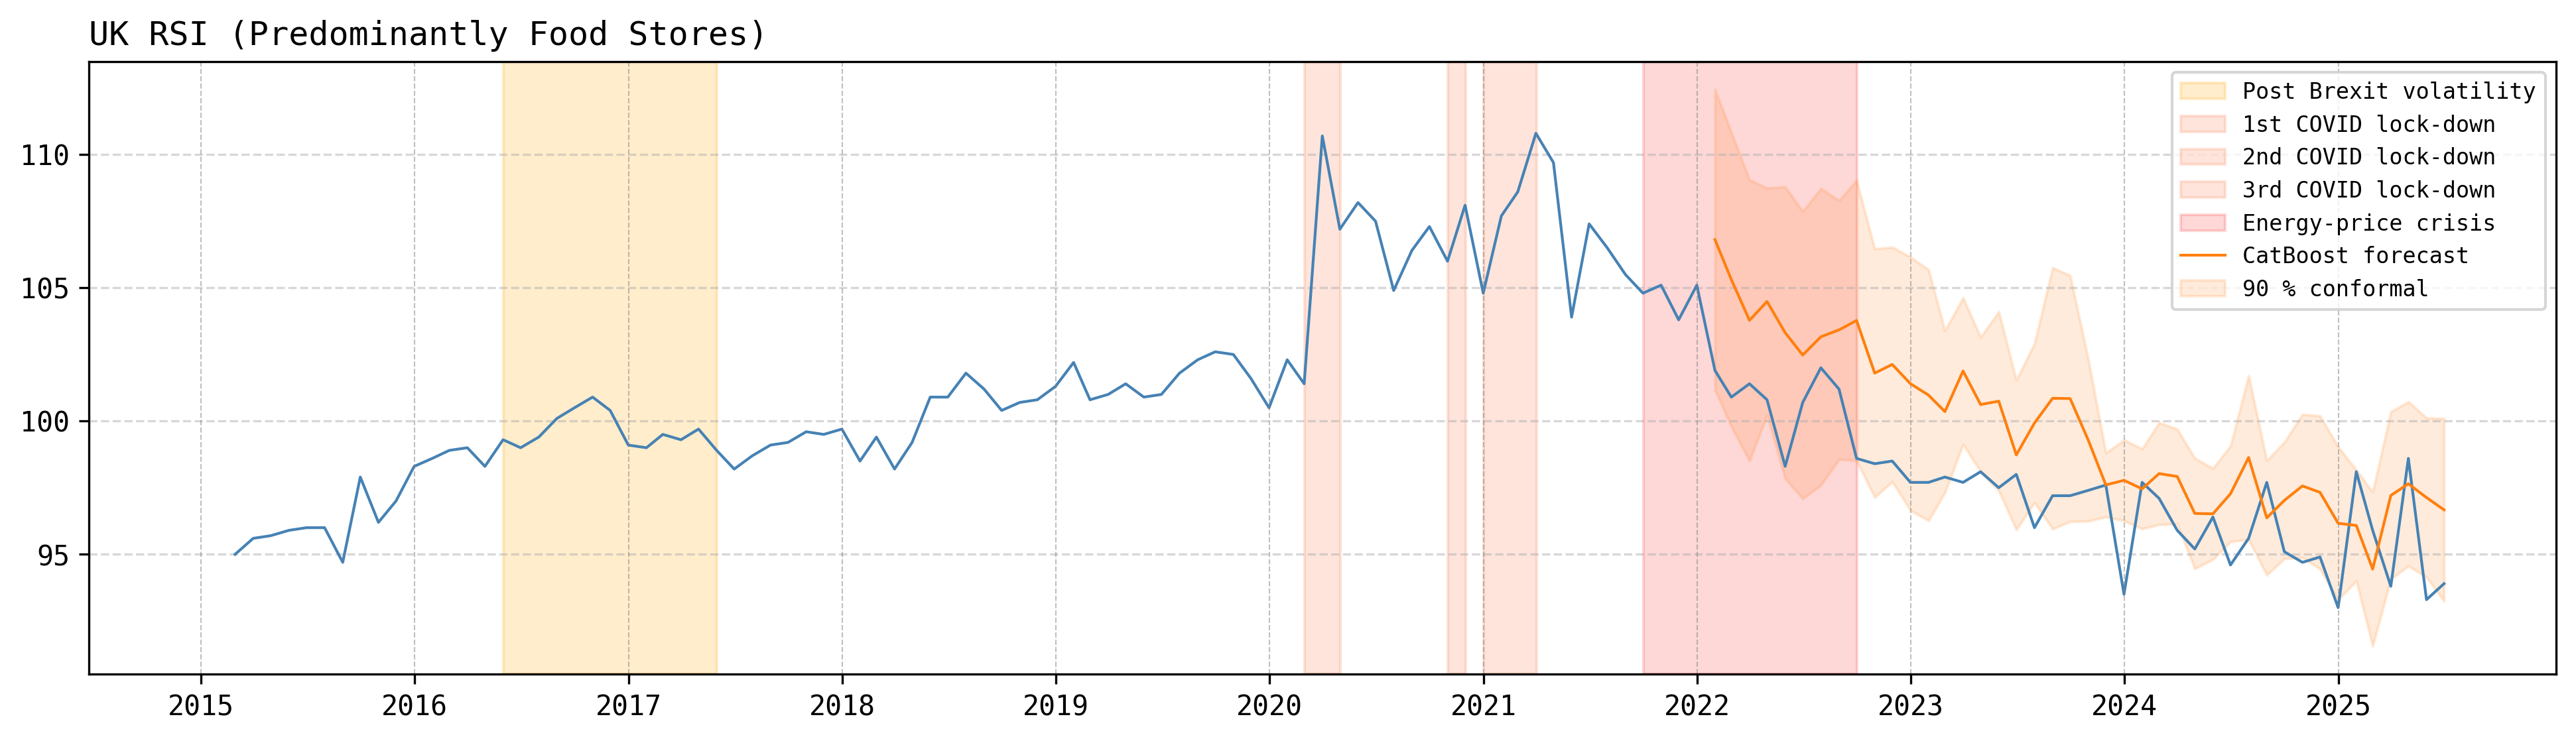

In [ ]:
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=df, x='date', y='Retail_sales_index', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

# Forecast line and PI
sns.lineplot(x=cb_forecast_df.index, y=cb_forecast_df['pred'],
             ax=ax, color='tab:orange', linewidth=1, label='CatBoost forecast')

ax.fill_between(cb_forecast_df.index,
                cb_forecast_df['lower'],
                cb_forecast_df['upper'],
                color='tab:orange', alpha=0.15, label='90 % conformal')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI (Predominantly Food Stores)', loc='left')
plt.show()

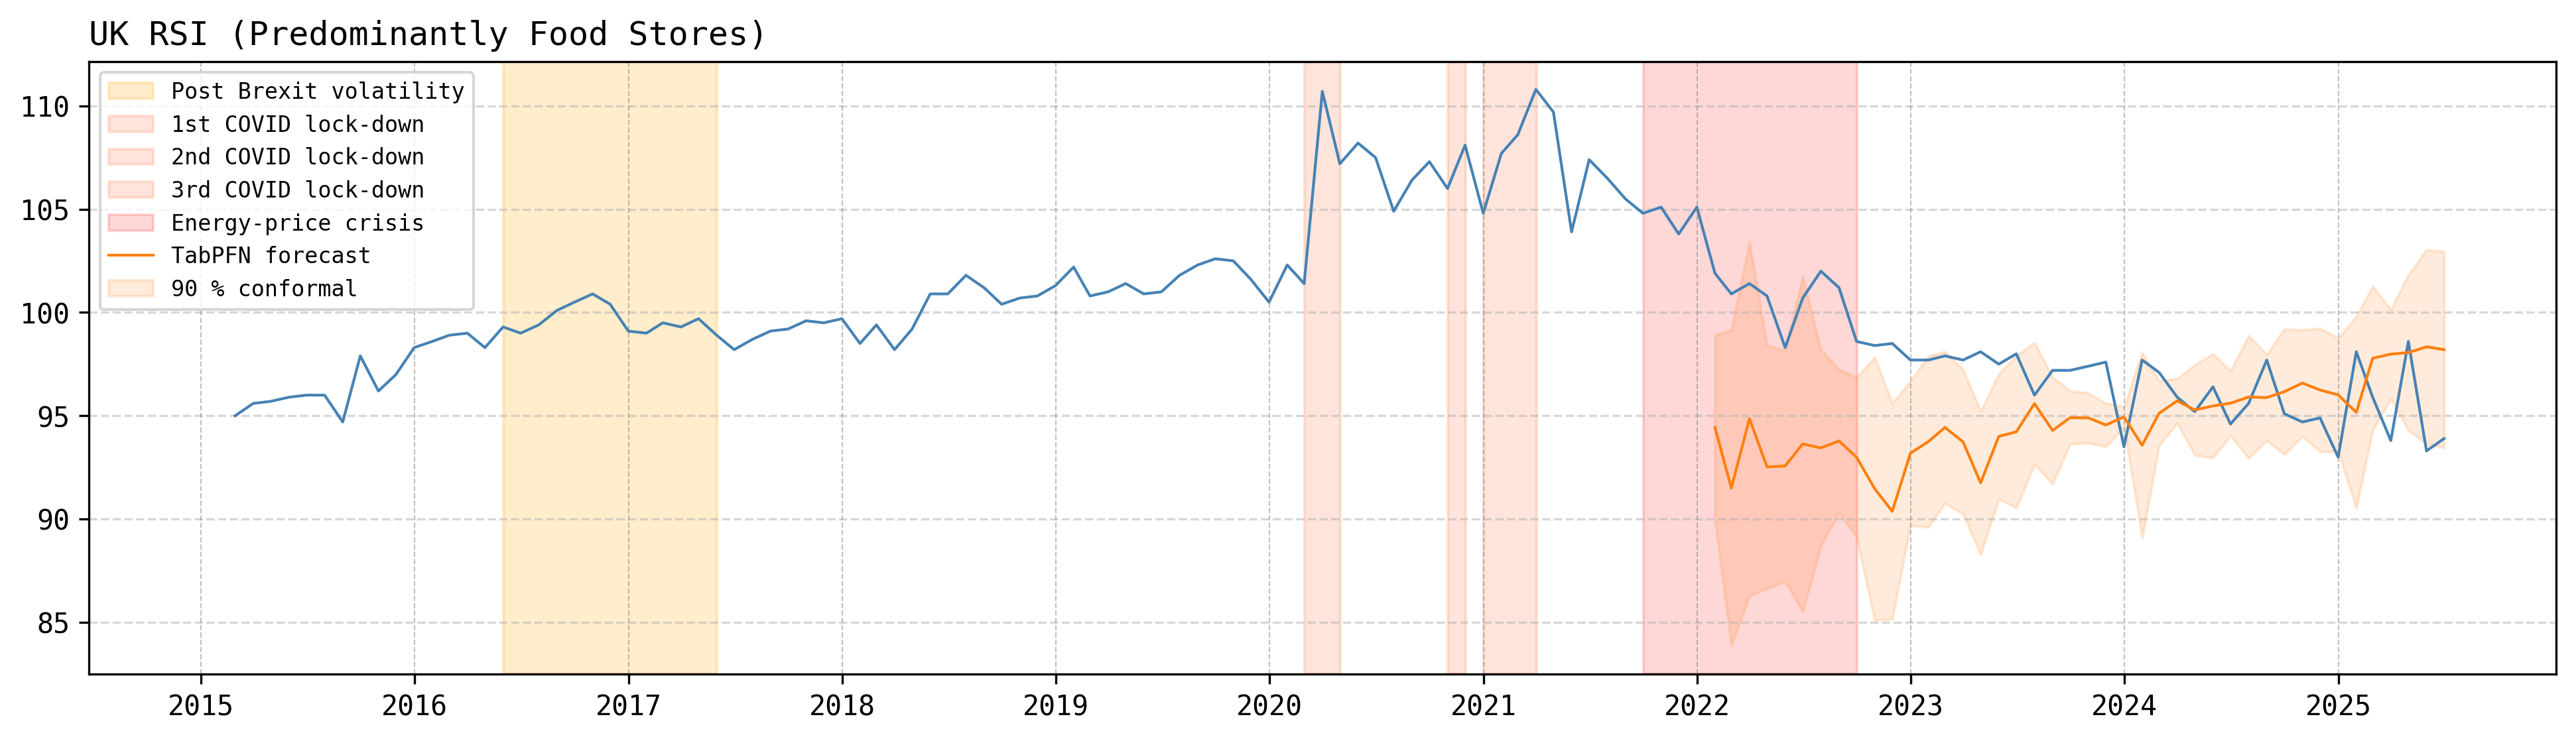

In [ ]:
plt.figure(figsize=(16, 4), dpi=300)

# Main RSI plot
ax = sns.lineplot(data=df, x='date', y='Retail_sales_index', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

# Forecast line and PI
sns.lineplot(x=tb_forecast_df.index, y=tb_forecast_df['pred'], ax=ax, color='tab:orange', linewidth=1, label='TabPFN forecast')
ax.fill_between(tb_forecast_df.index, tb_forecast_df['lower'], tb_forecast_df['upper'], color='tab:orange', alpha=0.15, label='90 % conformal')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI (Predominantly Food Stores)', loc='left')
plt.show()